# United States Extreme Climate Events Analysis

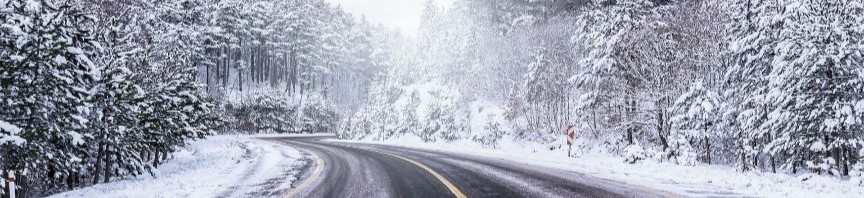

Predictive analysis of extreme weather events trends in the US using NOAA data and machine learning

### Initial Setup and Data Loading

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded successfully")

Libraries loaded successfully


In [19]:
# Cell 2: Load consolidated dataset
df = pd.read_csv('../data/processed/final_dataset.csv', low_memory=False)

print(f"Dataset shape: {df.shape}")
print(f"Total events: {len(df):,}")

# Show first few rows
df.head()

Dataset shape: (1520485, 52)
Total events: 1,520,485


,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,TOTAL_DEATHS
0,200012,31,600,200012,31,900,1104812,5165377,FLORIDA,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Temperatures fell into the mid-20s over Glades...,NaN,PDC,0
1,200012,31,600,200012,31,900,1104812,5165378,FLORIDA,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Temperatures fell into the mid-20s over Glades...,NaN,PDC,0
2,200012,31,700,200012,31,800,1104812,5165379,FLORIDA,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Temperatures fell into the mid-20s over Glades...,NaN,PDC,0
3,200012,13,2200,200012,14,400,1105342,5165449,WEST VIRGINIA,54.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"A mix of sleet, freezing rain and snow spread ...",NaN,PDC,0
4,200008,3,1410,200008,3,1410,1101140,5172568,MISSISSIPPI,28.0,...,NaN,FORKVILLE,32.45,-89.65,32.45,-89.65,NaN,Several trees were blown down along and onto h...,PDC,0


In [20]:
# Cell 3: Quick data overview
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1520485 entries, 0 to 1520484
Data columns (total 52 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   BEGIN_YEARMONTH     1520485 non-null  int64  
 1   BEGIN_DAY           1520485 non-null  int64  
 2   BEGIN_TIME          1520485 non-null  int64  
 3   END_YEARMONTH       1520485 non-null  int64  
 4   END_DAY             1520485 non-null  int64  
 5   END_TIME            1520485 non-null  int64  
 6   EPISODE_ID          1520485 non-null  int64  
 7   EVENT_ID            1520485 non-null  int64  
 8   STATE               1520484 non-null  str    
 9   STATE_FIPS          1520484 non-null  float64
 10  YEAR                1520485 non-null  int64  
 11  MONTH_NAME          1520485 non-null  str    
 12  EVENT_TYPE          1520485 non-null  str    
 13  CZ_TYPE             1520485 non-null  str    
 14  CZ_FIPS             1520485 non-null  int64  
 15  CZ_NAME             152048

In [21]:
# Cell 4: Check for missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing': missing,
    'Percentage': missing_pct
}).sort_values('Percentage', ascending=False)

print(missing_df[missing_df['Percentage'] > 0].head(15))

                    Missing  Percentage
CATEGORY            1519925   99.963170
TOR_OTHER_CZ_FIPS   1517028   99.772638
TOR_OTHER_CZ_STATE  1517028   99.772638
TOR_OTHER_WFO       1517028   99.772638
TOR_OTHER_CZ_NAME   1517028   99.772638
TOR_F_SCALE         1484774   97.651342
TOR_WIDTH           1484774   97.651342
TOR_LENGTH          1484774   97.651342
FLOOD_CAUSE         1402307   92.227612
MAGNITUDE_TYPE      1006236   66.178621
MAGNITUDE            718686   47.266892
BEGIN_RANGE          714591   46.997570
BEGIN_AZIMUTH        714591   46.997570
END_RANGE            714525   46.993229
END_AZIMUTH          714525   46.993229


### Data Cleaning and Preparation

In [22]:
# Cell 5: Convert date columns to datetime
df['BEGIN_DATE'] = pd.to_datetime(
    df['BEGIN_YEARMONTH'].astype(str) + df['BEGIN_DAY'].astype(str).str.zfill(2), 
    format='%Y%m%d', 
    errors='coerce'
)

df['END_DATE'] = pd.to_datetime(
    df['END_YEARMONTH'].astype(str) + df['END_DAY'].astype(str).str.zfill(2), 
    format='%Y%m%d', 
    errors='coerce'
)

# Extract temporal features
df['YEAR'] = df['BEGIN_DATE'].dt.year
df['MONTH'] = df['BEGIN_DATE'].dt.month
df['DECADE'] = (df['YEAR'] // 10) * 10

print("Date columns processed")
print(f"Period: {df['BEGIN_DATE'].min()} to {df['BEGIN_DATE'].max()}")
df[['BEGIN_DATE', 'YEAR', 'MONTH', 'DECADE']].head()

Date columns processed
Period: 2000-01-01 00:00:00 to 2024-12-31 00:00:00


,BEGIN_DATE,YEAR,MONTH,DECADE
0,2000-12-31,2000,12,2000
1,2000-12-31,2000,12,2000
2,2000-12-31,2000,12,2000
3,2000-12-13,2000,12,2000
4,2000-08-03,2000,8,2000


In [ ]:
# Cell 6: Clean damage columns (convert to numeric)
def convert_damage(value):
    """Convert NOAA damage format to numeric"""
    if pd.isna(value):
        return 0
    
    value = str(value).upper().strip()
    
    # Handle empty strings or zeros
    if value == '' or value == '0' or value == '0.00':
        return 0
    
    try:
        # Remove 'K', 'M', 'B' and convert
        if 'K' in value:
            num = value.replace('K', '').strip()
            return float(num) * 1000 if num else 0
        elif 'M' in value:
            num = value.replace('M', '').strip()
            return float(num) * 1000000 if num else 0
        elif 'B' in value:
            num = value.replace('B', '').strip()
            return float(num) * 1000000000 if num else 0
        else:
            # Direct number
            return float(value)
    except (ValueError, AttributeError):
        # If conversion fails, return 0
        return 0

# Apply conversion
df['DAMAGE_PROPERTY_NUM'] = df['DAMAGE_PROPERTY'].apply(convert_damage)
df['DAMAGE_CROPS_NUM'] = df['DAMAGE_CROPS'].apply(convert_damage)
df['TOTAL_DAMAGE'] = df['DAMAGE_PROPERTY_NUM'] + df['DAMAGE_CROPS_NUM']

print(" Damage columns converted to numeric")
print(f"\nTotal property damage: ${df['DAMAGE_PROPERTY_NUM'].sum()/1e9:.2f}B")
print(f"Total crop damage: ${df['DAMAGE_CROPS_NUM'].sum()/1e9:.2f}B")
print(f"Combined total: ${df['TOTAL_DAMAGE'].sum()/1e9:.2f}B")

# Show examples
print("\nSample conversions:")
print(df[['DAMAGE_PROPERTY', 'DAMAGE_PROPERTY_NUM']].head(10))

Damage columns converted to numeric

Total property damage: $523.43B
Total crop damage: $58.60B
Combined total: $582.03B

Sample conversions:
  DAMAGE_PROPERTY  DAMAGE_PROPERTY_NUM
0             NaN                  0.0
1             NaN                  0.0
2             NaN                  0.0
3             NaN                  0.0
4              2K               2000.0
5              2K               2000.0
6              1K               1000.0
7             NaN                  0.0
8             NaN                  0.0
9             NaN                  0.0


### Analysis 1 - Event Frequency Trends

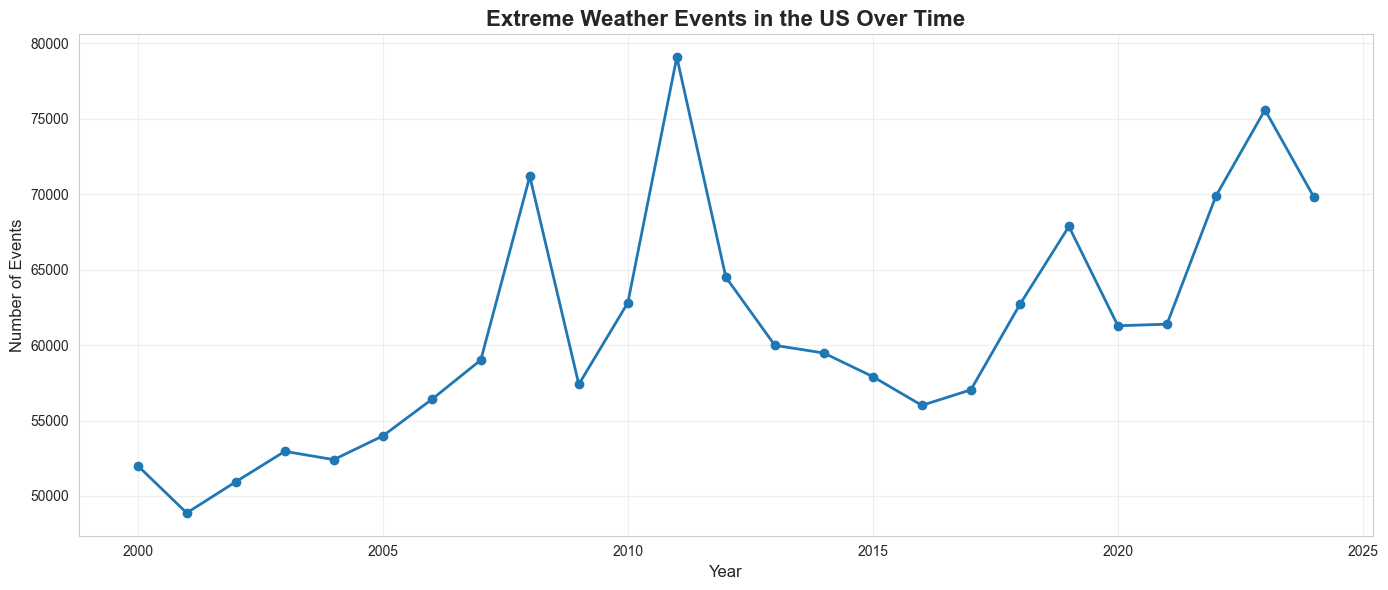

Total events: 1,520,485
Average per year: 60819
Peak year: 2011 with 79,091 events


In [24]:
# Cell 7: Events per year
events_per_year = df.groupby('YEAR').size().reset_index(name='COUNT')

plt.figure(figsize=(14, 6))
plt.plot(events_per_year['YEAR'], events_per_year['COUNT'], marker='o', linewidth=2)
plt.title('Extreme Weather Events in the US Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../images/01_events_trend.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Total events: {len(df):,}")
print(f"Average per year: {events_per_year['COUNT'].mean():.0f}")
print(f"Peak year: {events_per_year.loc[events_per_year['COUNT'].idxmax(), 'YEAR']:.0f} with {events_per_year['COUNT'].max():,} events")

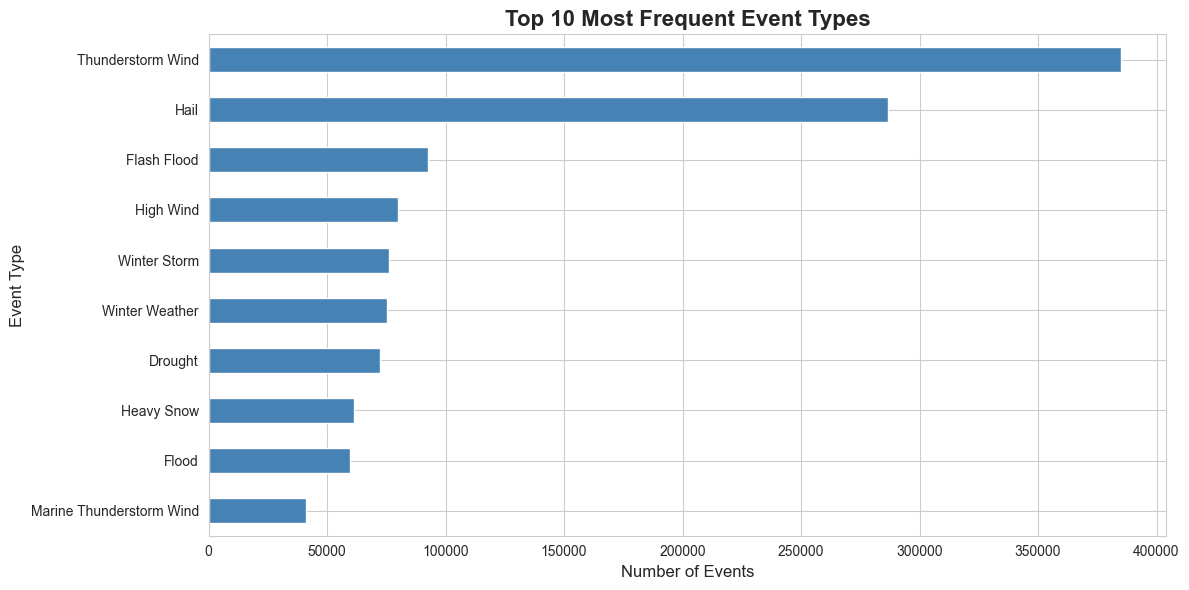


Top 10 Event Types:
EVENT_TYPE
Thunderstorm Wind           384896
Hail                        286508
Flash Flood                  92443
High Wind                    79767
Winter Storm                 76076
Winter Weather               75236
Drought                      72500
Heavy Snow                   61423
Flood                        59697
Marine Thunderstorm Wind     40894
Name: count, dtype: int64


In [25]:
# Cell 8: Top 10 event types
top_events = df['EVENT_TYPE'].value_counts().head(10)

plt.figure(figsize=(12, 6))
top_events.plot(kind='barh', color='steelblue')
plt.title('Top 10 Most Frequent Event Types', fontsize=16, fontweight='bold')
plt.xlabel('Number of Events', fontsize=12)
plt.ylabel('Event Type', fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../images/02_top_event_types.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 10 Event Types:")
print(top_events)

### Analysis 2 - Geographic Analysis

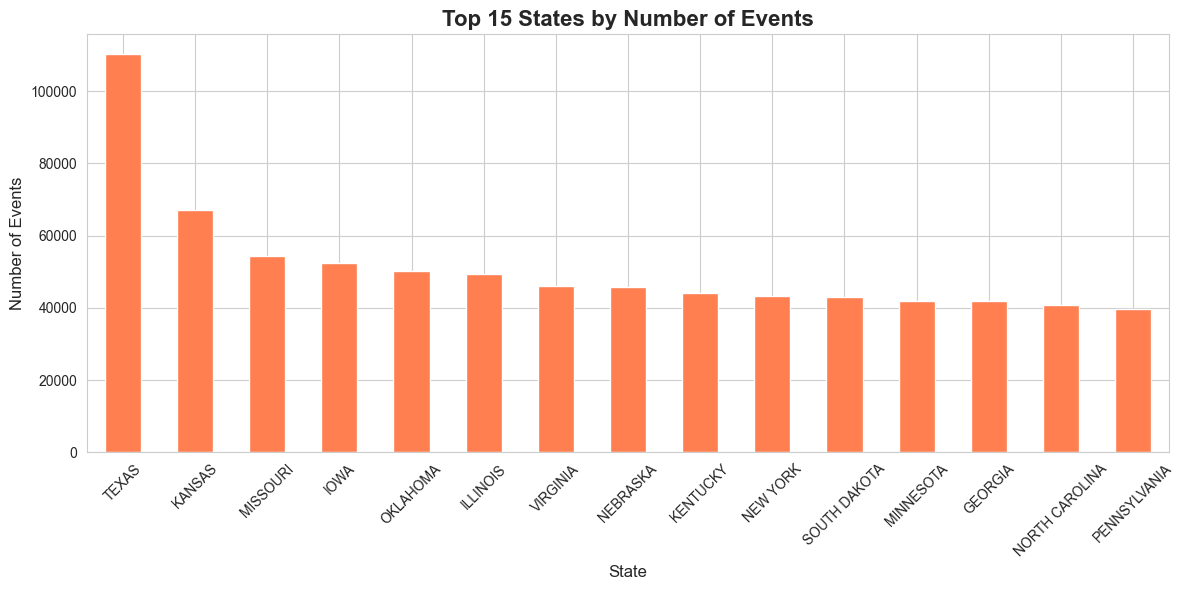

Top 15 States:
STATE
TEXAS             110220
KANSAS             67156
MISSOURI           54446
IOWA               52549
OKLAHOMA           50333
ILLINOIS           49377
VIRGINIA           46065
NEBRASKA           45860
KENTUCKY           44175
NEW YORK           43330
SOUTH DAKOTA       43078
MINNESOTA          41837
GEORGIA            41810
NORTH CAROLINA     40702
PENNSYLVANIA       39729
Name: count, dtype: int64


In [26]:
# Cell 9: Most affected states
top_states = df['STATE'].value_counts().head(15)

plt.figure(figsize=(12, 6))
top_states.plot(kind='bar', color='coral')
plt.title('Top 15 States by Number of Events', fontsize=16, fontweight='bold')
plt.xlabel('State', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../images/03_states_events.png', dpi=300, bbox_inches='tight')
plt.show()

print("Top 15 States:")
print(top_states)

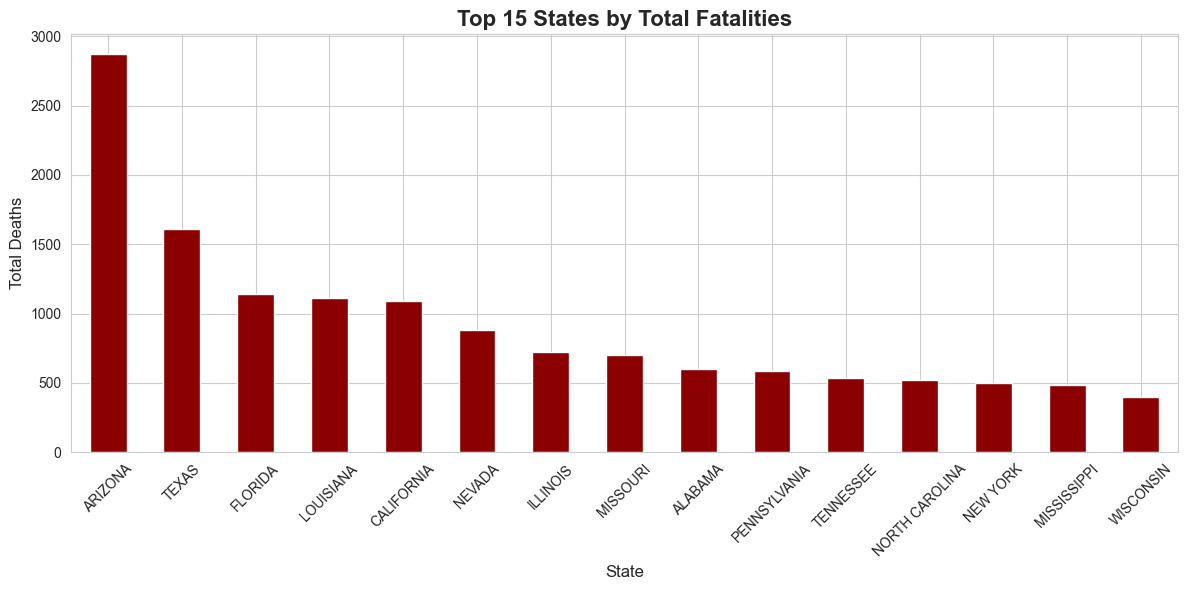


Total deaths from extreme weather: 20243
Events with fatalities: 11,348 (0.7%)


In [27]:
# Cell 10: Events with fatalities by state
fatal_events = df[df['TOTAL_DEATHS'] > 0]
deaths_by_state = fatal_events.groupby('STATE')['TOTAL_DEATHS'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 6))
deaths_by_state.plot(kind='bar', color='darkred')
plt.title('Top 15 States by Total Fatalities', fontsize=16, fontweight='bold')
plt.xlabel('State', fontsize=12)
plt.ylabel('Total Deaths', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../images/04_states_deaths.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTotal deaths from extreme weather: {df['TOTAL_DEATHS'].sum():.0f}")
print(f"Events with fatalities: {len(fatal_events):,} ({len(fatal_events)/len(df)*100:.1f}%)")

### Analysis 3 - Temporal Patterns

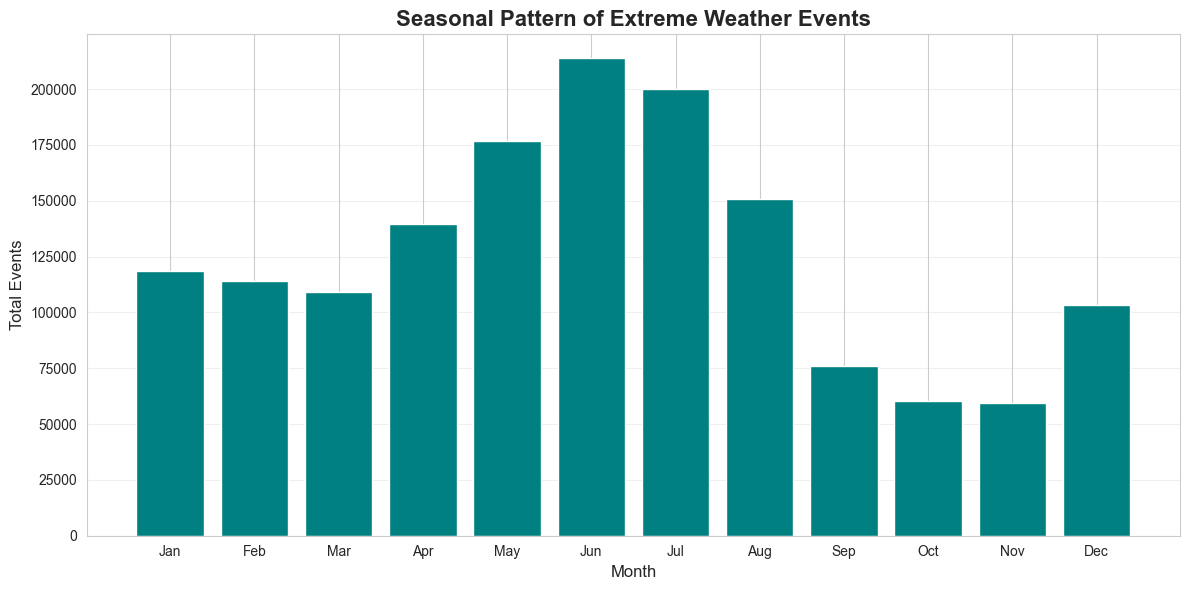

Events by month:
Jan: 118,506
Feb: 113,869
Mar: 108,968
Apr: 139,603
May: 176,821
Jun: 213,818
Jul: 199,863
Aug: 150,630
Sep: 75,857
Oct: 60,105
Nov: 59,264
Dec: 103,181


In [28]:
# Cell 11: Monthly seasonality
events_by_month = df.groupby('MONTH').size()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(12, 6))
plt.bar(range(1, 13), events_by_month.values, color='teal')
plt.title('Seasonal Pattern of Extreme Weather Events', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Events', fontsize=12)
plt.xticks(range(1, 13), month_names)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../images/05_monthly_pattern.png', dpi=300, bbox_inches='tight')
plt.show()

print("Events by month:")
for month, count in zip(month_names, events_by_month.values):
    print(f"{month}: {count:,}")

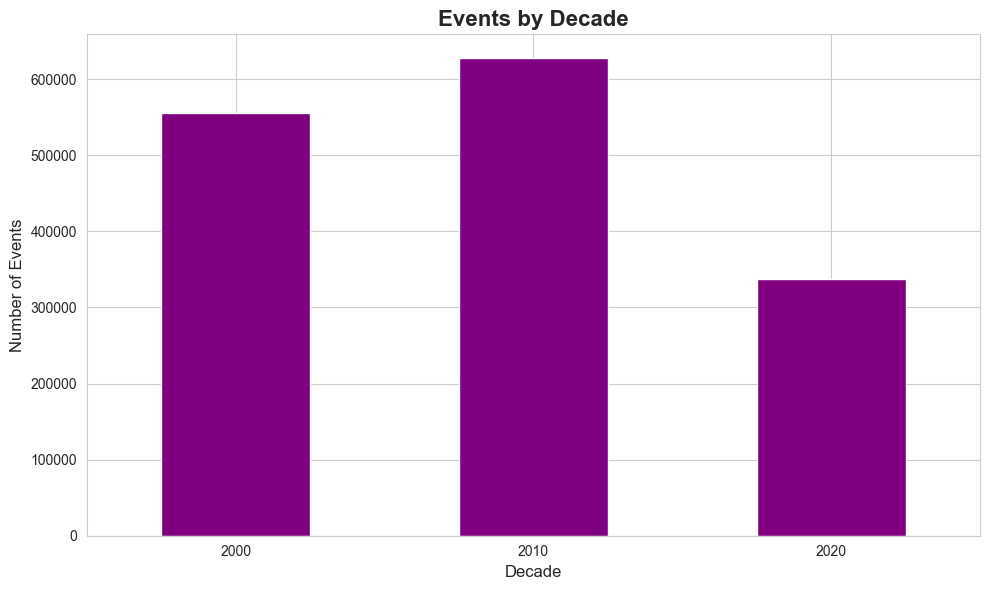

Growth rate:
2000s → 2010s: +13.0%
2010s → 2020s: -46.1%
The shrinkage at 2020 might be related to the COVID-19 pandemic, consequentially to a reduction of registering the events.


In [33]:
# Cell 12: Decade comparison
events_by_decade = df.groupby('DECADE').size()

plt.figure(figsize=(10, 6))
events_by_decade.plot(kind='bar', color='purple')
plt.title('Events by Decade', fontsize=16, fontweight='bold')
plt.xlabel('Decade', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../images/06_decade_trend.png', dpi=300, bbox_inches='tight')
plt.show()

print("Growth rate:")
for i in range(1, len(events_by_decade)):
    decade = events_by_decade.index[i]
    prev_decade = events_by_decade.index[i-1]
    growth = ((events_by_decade.iloc[i] - events_by_decade.iloc[i-1]) / events_by_decade.iloc[i-1]) * 100
    print(f"{prev_decade}s → {decade}s: {growth:+.1f}%")

print("The shrinkage at 2020 might be related to the COVID-19 pandemic, consequentially to a reduction of registering the events.")

### Analysis 4 - Economic Impact

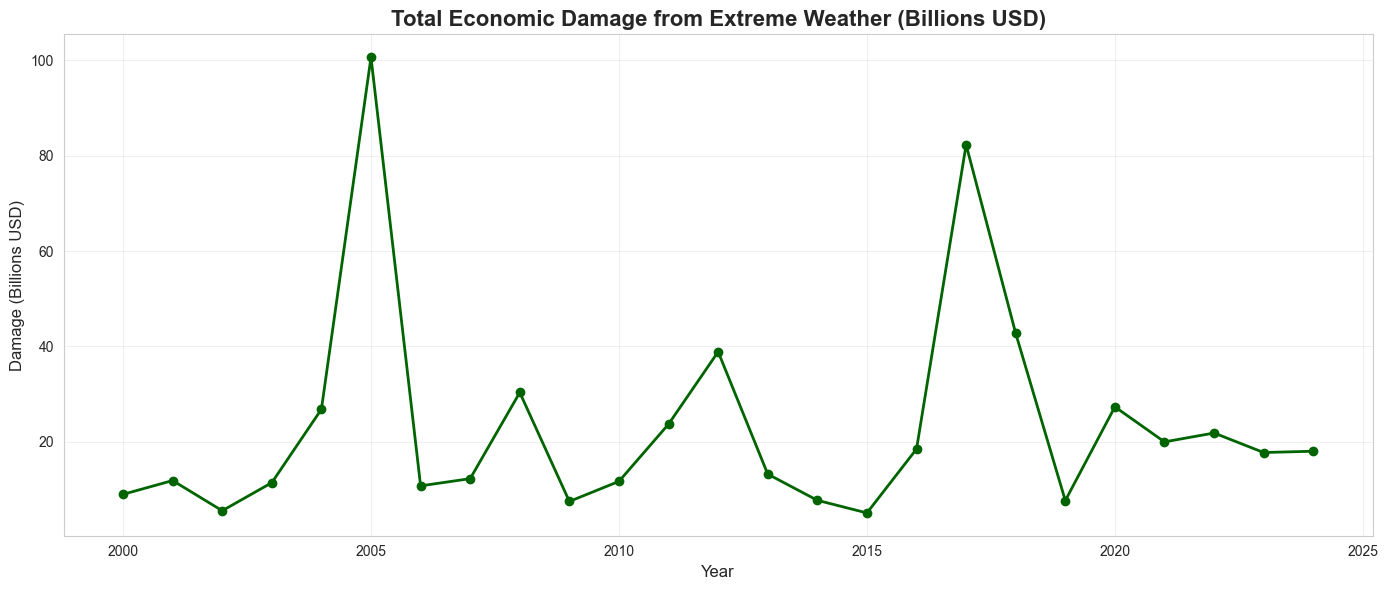

Total damage: $582.0B
Average per year: $23.3B
Worst year: 2005 ($100.7B)


In [32]:
# Cell 13: Total damages over time
damages_per_year = df.groupby('YEAR')['TOTAL_DAMAGE'].sum() / 1e9  # Convert to billions

plt.figure(figsize=(14, 6))
plt.plot(damages_per_year.index, damages_per_year.values, marker='o', linewidth=2, color='darkgreen')
plt.title('Total Economic Damage from Extreme Weather (Billions USD)', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Damage (Billions USD)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../images/07_economic_damage.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Total damage: ${df['TOTAL_DAMAGE'].sum()/1e9:.1f}B")
print(f"Average per year: ${damages_per_year.mean():.1f}B")
print(f"Worst year: {damages_per_year.idxmax()} (${damages_per_year.max():.1f}B)")

### Key Insights Summary

In [34]:
# Cell 14: Generate summary statistics
print("=" * 60)
print("KEY INSIGHTS - EXTREME WEATHER EVENTS ANALYSIS")
print("=" * 60)
print(f"\n📊 OVERALL STATISTICS")
print(f"Total events analyzed: {len(df):,}")
print(f"Time period: {df['YEAR'].min()}-{df['YEAR'].max()}")
print(f"Total fatalities: {df['TOTAL_DEATHS'].sum():.0f}")
print(f"Total economic damage: ${df['TOTAL_DAMAGE'].sum()/1e9:.1f} billion")

print(f"\n🔥 MOST COMMON EVENT TYPES")
for i, (event, count) in enumerate(top_events.head(5).items(), 1):
    print(f"{i}. {event}: {count:,} events ({count/len(df)*100:.1f}%)")

print(f"\n🌍 MOST AFFECTED STATES")
for i, (state, count) in enumerate(top_states.head(5).items(), 1):
    print(f"{i}. {state}: {count:,} events")

print(f"\n📈 TRENDS")
recent_5y = df[df['YEAR'] >= df['YEAR'].max() - 5]
older_5y = df[(df['YEAR'] >= df['YEAR'].min()) & (df['YEAR'] < df['YEAR'].min() + 5)]
trend = ((len(recent_5y)/5) - (len(older_5y)/5)) / (len(older_5y)/5) * 100
print(f"Frequency change (first 5y vs last 5y): {trend:+.1f}%")

print(f"\n💀 DEADLIEST EVENT TYPES")
deadly_events = df[df['TOTAL_DEATHS'] > 0].groupby('EVENT_TYPE')['TOTAL_DEATHS'].sum().sort_values(ascending=False).head(5)
for event, deaths in deadly_events.items():
    print(f"- {event}: {deaths:.0f} deaths")

print("=" * 60)

KEY INSIGHTS - EXTREME WEATHER EVENTS ANALYSIS

📊 OVERALL STATISTICS
Total events analyzed: 1,520,485
Time period: 2000-2024
Total fatalities: 20243
Total economic damage: $582.0 billion

🔥 MOST COMMON EVENT TYPES
1. Thunderstorm Wind: 384,896 events (25.3%)
2. Hail: 286,508 events (18.8%)
3. Flash Flood: 92,443 events (6.1%)
4. High Wind: 79,767 events (5.2%)
5. Winter Storm: 76,076 events (5.0%)

🌍 MOST AFFECTED STATES
1. TEXAS: 110,220 events
2. KANSAS: 67,156 events
3. MISSOURI: 54,446 events
4. IOWA: 52,549 events
5. OKLAHOMA: 50,333 events

📈 TRENDS
Frequency change (first 5y vs last 5y): +57.8%

💀 DEADLIEST EVENT TYPES
- Heat: 3037 deaths
- Excessive Heat: 2610 deaths
- Tornado: 1844 deaths
- Flash Flood: 1629 deaths
- Hurricane (Typhoon): 1339 deaths
